# Ensembling (kombinowanie prognoz)

Rodzina metod służących kombinowaniu uśrednianiu różnych modeli statystycznych w celu lepszego prognozowania. Wyróżniamy następujące typy ensemblingu:

• bagging – metoda służąca na oszacowaniu kilku takich samych modeli na losowej podpróbie (najczęściej bootstrapowanej) na tej samej populacji. Następnie prognoza jest uśredniana, ważona lub podejmuje się decyzję na zasadach głosowania (większość ma rację). Pozwalają uniknąć przetrenowania modelu, ale tracona jest zdolność do interpretacji zjawiska.

• lasy losowe (random forest) – metoda, polegająca na estymacji wielu „płytkich” drzew decyzyjnych na bootstrapowanych podpróbach, składających się z kilku losowo wybranych zmiennych. Metoda ta pozwala na przetrenowanie modeli za równo na wierszach (obserwacjach) jak i na kolumnach (zmiennych).

• boosting – zaawansowana metoda kombinowania prognoz, polega na wykorzystaniu wielu słabych klasyfikatorów w kombinowanej prognozie. Drzewa decyzyjne są zazwyczaj dopasowywane do reszt (różnicy między prognozą a rzeczywistością) z dotychczasowego modelu. Model ma wiele hiperparametrów, dlatego jest relatywnie trudny w optymalizacji i obsłudze – ale za to bardzo skuteczny.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#wyświetl wszystkie wiersze i kolumny
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('pm25.csv',index_col = 0, header = 0)
df = df.drop('pm25lag', axis = 1) #usunięcie zmiennej pm25 opóźnionej
df.head()

,Rok,Miesiąc,Dzień,Godzina,Wysokość_podstawy_niższej_[m],Wysokość_podstawy_wyższej_[m],Widzialność_operatora_[m],Widzialność_automat_[m],Zachmurzenie_ogólne_[oktanty],Kierunek_wiatru_[°],Prędkość_wiatru_[m/s],Poryw_wiatru_[m/s],Temperatura_powietrza_[°C],Temperatura_termometru_zwilżonego_[°C],Ciśnienie_pary_wodnej_[hPa],Wilgotność_względna_[%],Temperatura_punktu_rosy_[°C],Ciśnienie_na_pozimie_stacji_[hPa],Ciśnienie_na_pozimie_morza_[hPa],Wartość_tendencji_[wartość],Opad_za_6_godzin_[mm],Status_pomiaru_WO6G,Status_pomiaru_ROPT,Zachmurzenie_niskie_[oktanty],Niedosyt_wilgotności_[hPa},Usłonecznienie,Poryw_maksymalny_za_okres_WW_[m/s],Temperatura_gruntu_-5_[°C],Temperatura_gruntu_-10_[°C],Temperatura_gruntu_-20_[°C],Temperatura_gruntu_-50_[°C],Temperatura_gruntu_-100_[°C],Status_pomiaru_TG100,Temperatura_minimalna_za_12_godzin_[°C],Status_pomiaru_TMIN,Temperatura_maksymalna_za_12_godzin_[°C],Status_pomiaru_TMAX,Temperatura_minimalna_przy_gruncie_za_12_godzin_[°C],Status_pomiaru_TGMI,Równoważnik_wodny_śniegu_[mm/cm],Status_pomiaru_RWSN,Wysokość_pokrywy_śnieżnej_[cm],Status_pomiaru_PKSN,Wysokość_świeżo_spadłego_śniegu_[cm],Wysokość_śniegu_na_poletku_[cm],Wysokość_próbki_[cm],Ciężar_próbki_[g],Niepodległości,dzien_tygodnia
2014-01-01 01:00:00,2014.0,1.0,1.0,1.0,210.0,0.0,7000.0,0.0,8.0,119.0,4.0,0.0,1.0,0.0,6.1,93.0,0.0,1009.5,1023.0,-1.3,0.0,8.0,8.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,100.325798,3
2014-01-01 02:00:00,2014.0,1.0,1.0,2.0,210.0,0.0,7000.0,0.0,8.0,128.0,4.0,0.0,1.2,0.0,6.1,92.0,0.0,1009.0,1022.5,-1.0,0.0,8.0,8.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,69.412430,3
2014-01-01 03:00:00,2014.0,1.0,1.0,3.0,210.0,0.0,7000.0,0.0,8.0,134.0,3.0,0.0,1.3,0.0,6.2,92.0,0.1,1008.6,1022.1,-1.2,0.0,8.0,8.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,40.967861,3
2014-01-01 04:00:00,2014.0,1.0,1.0,4.0,210.0,0.0,7000.0,0.0,8.0,129.0,4.0,0.0,1.3,0.0,6.2,92.0,0.1,1008.2,1021.7,-1.3,0.0,8.0,8.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,37.308937,3
2014-01-01 05:00:00,2014.0,1.0,1.0,5.0,210.0,0.0,7000.0,0.0,8.0,137.0,4.0,0.0,1.3,0.0,6.1,91.0,0.0,1008.2,1021.7,-0.8,0.0,8.0,8.0,7.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,38.185955,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 2014-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Rok                                                   43824 non-null  float64
 1   Miesiąc                                               43824 non-null  float64
 2   Dzień                                                 43824 non-null  float64
 3   Godzina                                               43824 non-null  float64
 4   Wysokość_podstawy_niższej_[m]                         43824 non-null  float64
 5   Wysokość_podstawy_wyższej_[m]                         43824 non-null  float64
 6   Widzialność_operatora_[m]                             43824 non-null  float64
 7   Widzialność_automat_[m]                               43824 non-null  float64
 8   Zachmurzenie_ogólne_[oktanty]

In [4]:
feats = ['Rok', 'Miesiąc', 'Dzień', 'Godzina',
         'Zachmurzenie_ogólne_[oktanty]',
         'Kierunek_wiatru_[°]',
         'Prędkość_wiatru_[m/s]',
         'Temperatura_powietrza_[°C]',
         'Wilgotność_względna_[%]',
         'Ciśnienie_na_pozimie_stacji_[hPa]',
         'Ciśnienie_na_pozimie_morza_[hPa]',
         'dzien_tygodnia']

In [5]:
# podział zmiennych na objaśnianę i objaśniające
y = df['Niepodległości']
X = df[feats].values

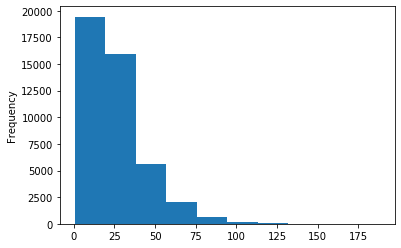

In [6]:
y.describe()

y.plot(kind='hist')
plt.show()

# Random forrest regressor

In [7]:
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Podział na zbiór treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(y_train.describe())
print(y_test.describe())

count    30676.000000
mean        26.131027
std         17.512920
min          0.832811
25%         13.588240
50%         21.513400
75%         33.480589
max        180.274778
Name: Niepodległości, dtype: float64
count    13148.000000
mean        26.241617
std         17.693262
min          0.877018
25%         13.588240
50%         21.513400
75%         33.634073
max        187.930147
Name: Niepodległości, dtype: float64


In [9]:
# Setup k-fold validation and method for model evaluation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

n_folds = 5

def scoring_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    r2= cross_val_score(model, X_train, y_train, scoring="r2", cv = kf)
    return rmse, r2

## Zmiany w stosunku do procedury z 11/02/2020


Duże wartości reszt silnie wpływają na MSE i RMSE, czego skutkiem jest fakt, że nawet gdy model wyjaśnia większość zmienności, pojedyncze wyjątki mogą znacznie wpłynąć na wartości współczynników.
Z tego względu zaleca się stosowanie MAE: Średni błąd absolutny (MAE) – mierzy dokładność prognozy, uśredniając wartości bezwzględne błędów, mniej wrażliwa na wpływ dużych wartości reszt.

Walidacja krzyżowa służy do:

• wykrywania zjawiska przetrenowania modeli

• poznania obiektywnej oceny skuteczności predykcyjnej tworzonego modelu (wartość oczekiwana i wariancja)

• strojeniu hiperparametrów wykorzystywanego modelu. 

Pojedyncza walidacja (jedna prognoza out-of-sample) prawie zawsze nie będzie wystarczającym i wartościowym miernikiem jakości modelu. Losowy nie jest synonimem słowa równy, ani reprezentatywny. W praktyce do znalezienia wartości oczekiwanej błędu potrzebujemy wielokrotnego powtórzenia prognozy out-of-sample na różnych próbach walidacyjnych.
Stąd, zwiększamy n_folds z 5 do 10. 

In [10]:
# Setup k-fold validation and method for model evaluation 
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score

n_folds = 10

def scoring_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    r2= cross_val_score(model, X_train, y_train, scoring="r2", cv = kf)
    mae = -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf)
    return rmse, r2, mae

## Train a default random forest model

In the Random Forest model, the original training data is randomly sampled-with-replacement generating small subsets of data
These subsets are also known as bootstrap samples. These bootstrap samples are then fed as training data to many DTs of large depths. Each of these DTs is trained separately on these bootstrap samples. This aggregation of DTs is called the Random Forest ensemble. The concluding result of the ensemble model is determined by counting a majority vote from all the DTs. This concept is known as Bagging or Bootstrap Aggregation. Since each DT takes a different set of training data as input, the deviations in the original training dataset do not impact the final result obtained from the aggregation of DTs. Therefore, bagging as a concept reduces variance without changing the bias of the complete ensemble.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Default:

n_estimators=100, min_samples_leaf=1, max_features=X_train.shape[1], max_samples=X_train.shape[0]

In [11]:
print(X_train.shape)

rm_reg = RandomForestRegressor(n_estimators = 100, 
                             random_state = 0)                                             

(30676, 12)


In [12]:
# Fit and validate the default model with a 10-fold CV

score = scoring_cv(rm_reg)
print("rm_reg rmse: {:.4f} ({:.4f}), r2: {:.1f}%, mae: {:.4f} \n" .format(score[0].mean(), score[0].std(), 100*score[1].mean(), score[2].mean()))
                  

rm_reg rmse: 7.8401 (0.3260), r2: 79.9%, mae: 5.0543 



Aby wybrać odpowiednią złożoność estymatora możemy spojrzeć na wyniki na zbiorze walidacyjnym. 
Podjęcie takiego działania oznacza jednak, że wykorzystujemy zbiór walidacyjny na potrzeby trenowania estymatora. 
Jest to swego rodzaju przeciek informacyjny. W większości przypadków skutki takiego przecieku będą niewielkie 
i nie popełnimy dużego błędu (tworząc nieoptymalny estymator).
Warto jednak o tym pamiętać i w stosownych sytuacjach stosować procedurę: train, validate, test. 
Idea jest dokładnie taka sama jak w walidacji krzyżowej, z tym że część zbioru odkładamy na bok i 
nie wykorzystujemy go do samego końca naszych działań treningowych.

## Test the default model on test data

In [13]:
rm_reg.fit(X_train, y_train)
y_test_pred = rm_reg.predict(X_test)

from sklearn import metrics
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)),4))  
print('MAE:', round(metrics.mean_absolute_error(y_test, y_test_pred),4)) 

RMSE: 7.5634
MAE: 4.9177


## Tune parameters, use 10-fold CV

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [14]:
# Apply Grid Search to find optimal parameters

from sklearn.model_selection import GridSearchCV

parameters = {'max_features': [8, 10, 12], 
              'min_samples_leaf': range(1,30,5), 
              'n_estimators': [80, 100, 120]}

grid_search = GridSearchCV(estimator= rm_reg, 
                           param_grid = parameters, 
                           scoring = 'neg_root_mean_squared_error', #RMSE
                            cv = 10, 
                            n_jobs = -1, 
                            return_train_score=True)

In [15]:
# Fit random forest to train data, apply grid search

rm_reg_gs = grid_search.fit(X_train, y_train)

In [16]:
# Return train score history for all combinations of parameters

cv_results = pd.DataFrame(rm_reg_gs.cv_results_)
print(cv_results[['params', 'mean_train_score']])

                                               params  mean_train_score
0   {'max_features': 8, 'min_samples_leaf': 1, 'n_...         -2.905089
1   {'max_features': 8, 'min_samples_leaf': 1, 'n_...         -2.878758
2   {'max_features': 8, 'min_samples_leaf': 1, 'n_...         -2.860367
3   {'max_features': 8, 'min_samples_leaf': 6, 'n_...         -6.469239
4   {'max_features': 8, 'min_samples_leaf': 6, 'n_...         -6.456113
5   {'max_features': 8, 'min_samples_leaf': 6, 'n_...         -6.439750
6   {'max_features': 8, 'min_samples_leaf': 11, 'n...         -7.942661
7   {'max_features': 8, 'min_samples_leaf': 11, 'n...         -7.930999
8   {'max_features': 8, 'min_samples_leaf': 11, 'n...         -7.919705
9   {'max_features': 8, 'min_samples_leaf': 16, 'n...         -8.771206
10  {'max_features': 8, 'min_samples_leaf': 16, 'n...         -8.761938
11  {'max_features': 8, 'min_samples_leaf': 16, 'n...         -8.749618
12  {'max_features': 8, 'min_samples_leaf': 21, 'n...         -9

In [22]:
# Distribution of RMSE for training and test datasets
cv_results[['mean_test_score', 'mean_train_score']].describe()

,mean_test_score,mean_train_score
count,54.000000,54.000000
mean,-9.455956,-7.480939
std,0.952055,2.321455
min,-10.523664,-9.695924
25%,-10.245729,-9.270032
50%,-9.724201,-8.323935
75%,-8.793560,-6.392932
max,-7.619673,-2.860367


In [23]:
# Return parameter setting that gave the best results on the hold out data
best_parameters = rm_reg_gs.best_params_
print(best_parameters)

#{'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 120}

{'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 120}


In [24]:
# Define best random forest model (more tunning may be needed!)

rm_reg_best = RandomForestRegressor(n_estimators = 120,
                                    min_samples_leaf=1, 
                                    max_features=8, 
                                    random_state = 0, 
                                    oob_score=False)

In [25]:
# Fit and evaluate (validation dataset)

score_best = scoring_cv(rm_reg_best)
print("rm_reg_best rmse: {:.4f} ({:.4f}), r2: {:.1f}%, mae: {:.4f} \n" .format(score_best[0].mean(), score_best[0].std(), 100*score_best[1].mean(), score_best[2].mean()))
 
# Default model results (rm_reg) rmse: 7.8401 (0.3260), r2: 79.9%, mae: 5.0543

rm_reg_best rmse: 7.6197 (0.3344), r2: 81.0%, mae: 4.9369 



In [26]:
# Test the model on test data
rm_reg_best.fit(X_train, y_train)
y_test_best_pred = rm_reg_best.predict(X_test)

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_best_pred)),4))  
print('MAE:', round(metrics.mean_absolute_error(y_test, y_test_best_pred),4)) 

# RMSE: 7.5634
# MAE: 4.9177

RMSE: 7.3352
MAE: 4.7798
